<a href="https://colab.research.google.com/github/younhuiji/python/blob/main/07_Histology_Image_weakly_supervised_Learning_Segmentation_patch_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# 구글 드라이브 마운트

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# 데이터 준비 및 전처리

### 필요한 데이터 다운 받기

**Histological tile 이미지 (5000장, 150x150 픽셀 (74x74 µm))**

```
Kather_texture_2016_image_tiles_5000
|--01_TUMOR
|    |--10009_CRC-Prim-HE-03_009.tif_Row_301_Col_151.tif
|    |--10062_CRC-Prim-HE-02_003b.tif_Row_1_Col_301.tif
|    |--100B0_CRC-Prim-HE-09_009.tif_Row_1_Col_301.tif
|     ...
|--02_STROMA
|    |--10009_CRC-Prim-HE-03_009.tif_Row_301_Col_151.tif
|    |--1000E_CRC-Prim-HE-04.tif_Row_1501_Col_451.tif
|    |--10049_CRC-Prim-HE-07_014.tif_Row_601_Col_3001.tif
|    ...


```

In [ ]:
# 5000 150 * 150 histological 이미지 (74 * 74 µm)
# !wget -O histology_dataset.zip --no-check-certificate https://zenodo.org/record/1214456/files/NCT-CRC-HE-100K.zip?download=1

!unzip /content/drive/MyDrive/test1/3강_histology/histology_dataset.zip # 압축 풀기
# !unzip histology_dataset.zip # 압축 풀기

스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
  inflating: Kather_texture_2016_image_tiles_5000/01_TUMOR/10264_CRC-Prim-HE-07_025.tif_Row_1801_Col_1.tif  
  inflating: Kather_texture_2016_image_tiles_5000/01_TUMOR/10286_CRC-Prim-HE-01_002.tif_Row_301_Col_1.tif  
  inflating: Kather_texture_2016_image_tiles_5000/01_TUMOR/1030D_CRC-Prim-HE-02_031.tif_Row_151_Col_1.tif  
  inflating: Kather_texture_2016_image_tiles_5000/01_TUMOR/103B7_CRC-Prim-HE-02_026.tif_Row_1_Col_451.tif  
  inflating: Kather_texture_2016_image_tiles_5000/01_TUMOR/103F_CRC-Prim-HE-02_025.tif_Row_1_Col_301.tif  
  inflating: Kather_texture_2016_image_tiles_5000/01_TUMOR/103F_CRC-Prim-HE-10_013.tif_Row_151_Col_1.tif  
  inflating: Kather_texture_2016_image_tiles_5000/01_TUMOR/10437_CRC-Prim-HE-02_028.tif_Row_151_Col_451.tif  
  inflating: Kather_texture_2016_image_tiles_5000/01_TUMOR/104D5_CRC-Prim-HE-09_024.tif_Row_451_Col_151.tif  
  inflating: Kather_texture_2016_image_tiles_5000/01_TUMOR/1055E_CRC-Prim-HE-01_027.tif_Row_151_C

[1000000_colon_histological_images](https://zenodo.org/record/1214456/#.YsjR3OxBw0Q)

### 다운 받은 데이터 확인

In [ ]:
import os

In [ ]:
def print_files_in_dir(root_dir, prefix):
    files = os.listdir(root_dir)
    for file in files:
        path = os.path.join(root_dir, file)
        file_list = os.listdir(path)
        print(f"{prefix + path} 폴더의 데이터 수: {len(file_list)}")
        # print(f"해당 폴더의 데이터의 수 {len(file_list)}")

In [ ]:
print_files_in_dir("Kather_texture_2016_image_tiles_5000", "")

Kather_texture_2016_image_tiles_5000/05_DEBRIS 폴더의 데이터 수: 625
Kather_texture_2016_image_tiles_5000/06_MUCOSA 폴더의 데이터 수: 625
Kather_texture_2016_image_tiles_5000/07_ADIPOSE 폴더의 데이터 수: 625
Kather_texture_2016_image_tiles_5000/08_EMPTY 폴더의 데이터 수: 625
Kather_texture_2016_image_tiles_5000/04_LYMPHO 폴더의 데이터 수: 625
Kather_texture_2016_image_tiles_5000/01_TUMOR 폴더의 데이터 수: 625
Kather_texture_2016_image_tiles_5000/02_STROMA 폴더의 데이터 수: 625
Kather_texture_2016_image_tiles_5000/03_COMPLEX 폴더의 데이터 수: 625


### 학습, 검증 데이터 준비

In [ ]:
def create_dir(dir_name : str):
  """
  디렉토리가 존재하지 않으면 생성
  """
  if not os.path.exists(dir_name):
      os.makedirs(dir_name)

In [ ]:
image_file_root      = "Kather_texture_2016_image_tiles_5000"
train_dataset_folder = "training_dataset" # 학습 데이터 저장할 폴더
val_dataset_folder   = "validation_dataset" # 검증 데이터 저장할 폴더

In [ ]:
files = os.listdir(image_file_root)

In [ ]:
files.sort() # 클래스 번호로 정렬하기
files

['01_TUMOR',
 '02_STROMA',
 '03_COMPLEX',
 '04_LYMPHO',
 '05_DEBRIS',
 '06_MUCOSA',
 '07_ADIPOSE',
 '08_EMPTY']



![](https://media.springernature.com/full/springer-static/image/art%3A10.1038%2Fsrep27988/MediaObjects/41598_2016_Article_BFsrep27988_Fig1_HTML.jpg?as=webp)



In [ ]:
create_dir(train_dataset_folder) # 학습 데이터 저장할 폴더 생성
create_dir(val_dataset_folder) # 검증 데이터 저장할 폴더 생성

# 클래스별 서브 디렉토리 생성
for class_name in files:
  train_sub_folder_path = os.path.join(train_dataset_folder, class_name)
  create_dir(train_sub_folder_path)
  val_sub_folder_path = os.path.join(val_dataset_folder, class_name)
  create_dir(val_sub_folder_path)


In [ ]:
import random
from shutil import copyfile

In [ ]:
# 전체 데이터에서 학습 / 검증 데이터 나누기

for class_name in files:
  image_files = os.listdir(os.path.join(image_file_root, class_name)) # 전체 이미지
  random.shuffle(image_files) # 이미지 랜덤하게 섞기

  train_image_list = image_files[:500] # 학습데이터 (500장)
  val_image_list = image_files[500:] # 검증데이터 (나머지)

  # 학습데이터 폴더와 검증데이터 폴더에 나누어 저장하기
  for train_image in train_image_list:
    copyfile(os.path.join(image_file_root, class_name, train_image), os.path.join(train_dataset_folder, class_name, train_image))
  for val_image in val_image_list:
    copyfile(os.path.join(image_file_root, class_name, val_image), os.path.join(val_dataset_folder, class_name, val_image))


### 데이터 전처리

In [ ]:
# 필요한 모듈 불러오기

import torch
from torchvision import datasets, models, transforms
from torchvision.models import resnet50
from torch.utils.tensorboard import SummaryWriter
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
# from nets import *
import time, os, copy, argparse
import multiprocessing
from torchsummary import summary
from matplotlib import pyplot as plt

import cv2
import numpy as np

import torch.utils.data as data

In [ ]:
# 데이터 transform 적용하기

image_transforms = {
    'train': transforms.Compose([
        transforms.Resize(size=224), # 패치 사이즈 224로 만들기
        transforms.ToTensor(),       # 텐서로 변환

        # 데이터 augmentaion
        transforms.RandomRotation(90, expand=False),  # 90도 회전
        transforms.RandomRotation(180, expand=False), # 180도 회전
        transforms.RandomRotation(270, expand=False), # 270도 회전

        # 이미지 정규화 (각 채널의 평균, 표준편차 값)
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),

    'valid': transforms.Compose([
        transforms.Resize(size=224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
}

In [ ]:
# train_directory = './training_dataset' # training 데이터 경로
# valid_directory = './validation_dataset' # validation 데이터 경로
# PATH            = "model.pth" # 사전에 저장된 모델 경로

In [ ]:
bs = 32 # 미니 배치(mini-batch) 학습을 위한 Batch size

# 경로에서 데이터 불러오기
dataset = {
    'train': datasets.ImageFolder(root=train_dataset_folder, transform=image_transforms['train']),
    'valid': datasets.ImageFolder(root=val_dataset_folder, transform=image_transforms['valid'])
}

# 각 데이터 크기 저장
dataset_sizes = {
    'train':len(dataset['train']),
    'valid':len(dataset['valid'])
}

# mini-batch 학습을 위한 iterators 객체 만들기
dataloaders = {
    'train':data.DataLoader(dataset['train'], batch_size=bs, shuffle=True,
                            num_workers=1, pin_memory=True, drop_last=False),
    'valid':data.DataLoader(dataset['valid'], batch_size=bs, shuffle=False,
                            num_workers=1, pin_memory=True, drop_last=False)
}


# 클래스 이름 출력
class_names = dataset['train'].classes
print("Classes:", class_names)


# 학습 / 검증 데이터 사이즈 출력
print("Training-set size:",dataset_sizes['train'],
      "\nValidation-set size:", dataset_sizes['valid'])

Classes: ['01_TUMOR', '02_STROMA', '03_COMPLEX', '04_LYMPHO', '05_DEBRIS', '06_MUCOSA', '07_ADIPOSE', '08_EMPTY']
Training-set size: 4000 
Validation-set size: 1000


In [ ]:
# Train DataLoader 데이터 확인해보기

for x, y in dataloaders['train']:
    print(x.shape)
    print(y.shape)
    break

torch.Size([32, 3, 224, 224])
torch.Size([32])


In [ ]:
# Valid DataLoader 데이터 확인해보기

for x, y in dataloaders['valid']:
    print(x.shape)
    print(y.shape)
    break

torch.Size([32, 3, 224, 224])
torch.Size([32])


# 모델 학습 (Model training)

### 모델 학습을 위한 설정

In [ ]:
# 학습에 필요한 변수 설정

train_epoch   = 10 # Number of epochs
learning_rate = 0.005 # Learning rate for optimizer

In [ ]:
# 디바이스 설정 (GPU 사용 가능하면 GPU 사용하도록)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# ImageNet 데이터로 사전학습된 resnet50 모델 불러오기
model = resnet50(pretrained=True)

# resnet50의 마지막 층 교체
# (2048 -> 1000) => (2048 -> 128 -> num_classes)
model.fc = nn.Sequential(
              nn.Linear(2048, 128),
              nn.ReLU(inplace=True),
              nn.Linear(128, 8))


# 모델 GPU 메모리에 올리기
model = model.to(device)

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

In [ ]:
model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [ ]:
# 손실 함수 정의하기
loss_fn = nn.CrossEntropyLoss()

# Optimizer (Stochastic Gradient Descent)
opt = optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)

# Learning rate decay
scheduler = lr_scheduler.StepLR(opt, step_size=7, gamma=0.1)

### 모델 학습 진행

In [ ]:
import time
import copy

In [ ]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=30):
    """모델 학습을 위한 함수

    args:
      model: 사전엔 생성된 모델 인스턴스
      criterion: 모델 학습 및 평가에 활용 되는 손실 함수
      optimzer: gradient 값을 바탕으로 매개변수를 업데이트
      scheduler: 학습 과정 동안 학습률(learning rate) 조정
      num_epochs: 학습 시 최대 epoch 수 (default: 30)

    return:
      학습된 모델 반환
    """
    since = time.time() # 학습 시작 시간 기록

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0


    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # 각 epoch 마다 학습과 검증 수행
        for phase in ['train', 'valid']:
            if phase == 'train':
                model.train()  # training 모드로 전환
            else:
                model.eval()   # evalutation 모드로 전환

            running_loss = 0.0
            running_corrects = 0

            # 미니 배치(mini-batch) 학습
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # gradient를 0으로 초기화
                optimizer.zero_grad()

                # 순전파(forward)
                # 학습 과정에서만 연산 기록 추적
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # 학습 과정에서만
                    if phase == 'train':
                        loss.backward() # 오차 역전파(backward)
                        optimizer.step() # 매개변수 업데이트

                # 손실 값(loss)과 정확도(accuracy) 계산을 위한 통계랑 저장
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            # 평균 손실 값과 정확도
            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

            # 검증 정확도가 가장 높은 모델 저장하기
            if phase == 'valid' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since # 학습 종료 시간 기록
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # 검증 시 정확도가 제일 높은 모델 불러오기
    model.load_state_dict(best_model_wts)
    return model

In [ ]:
# Model training routine
print("\nTraining:-\n")

model = train_model(model, loss_fn, opt, scheduler, num_epochs=train_epoch)


Training:-

Epoch 0/9
----------
train Loss: 0.7946 Acc: 0.7325
valid Loss: 0.3029 Acc: 0.9110

Epoch 1/9
----------
train Loss: 0.3229 Acc: 0.8860
valid Loss: 0.2990 Acc: 0.9000

Epoch 2/9
----------
train Loss: 0.2453 Acc: 0.9145
valid Loss: 0.2282 Acc: 0.9210

Epoch 3/9
----------
train Loss: 0.2384 Acc: 0.9175
valid Loss: 0.2558 Acc: 0.9330

Epoch 4/9
----------
train Loss: 0.2080 Acc: 0.9280
valid Loss: 0.1621 Acc: 0.9510

Epoch 5/9
----------
train Loss: 0.1948 Acc: 0.9335
valid Loss: 0.2393 Acc: 0.9150

Epoch 6/9
----------
train Loss: 0.1604 Acc: 0.9473
valid Loss: 0.2360 Acc: 0.9170

Epoch 7/9
----------
train Loss: 0.1270 Acc: 0.9543
valid Loss: 0.0945 Acc: 0.9710

Epoch 8/9
----------
train Loss: 0.1094 Acc: 0.9615
valid Loss: 0.0947 Acc: 0.9710

Epoch 9/9
----------
train Loss: 0.0945 Acc: 0.9693
valid Loss: 0.0949 Acc: 0.9720

Training complete in 10m 8s
Best val Acc: 0.972000


# 모델 테스트 (Model testing)

### validation 데이터로 학습된 모델 테스트

In [ ]:
pred_all =[] # 예측 값
label_all = [] # 참 값

# 검증데이터
for v_i, label in dataloaders['valid']:
    # 입력 값과 참 값 device에 올리기
    v_i = v_i.to(device)
    label = label.to(device)

    with torch.no_grad():
        pred = model(v_i) # 순전파(forward pass)
        pred = nn.Softmax(dim=1)(pred)
        pred = pred.cpu().numpy() # 예측 값 cpu 메모리로 옮기고 넘파이로 변환
        pred_all.append(pred)

    label = label.cpu().numpy()
    label_all.append(label)

pred_all = np.concatenate(pred_all)
label_all = np.concatenate(label_all)


In [ ]:
from sklearn.metrics import classification_report

In [ ]:
# argmax 함수로 샘플 마다 확률 값이 가장 높은 클래스 선택
pred_all_argmax = np.argmax(pred_all, axis=1)

target_names = ['01_TUMOR', '02_STROMA', '03_COMPLEX', '04_LYMPHO', '05_DEBRIS', '06_MUCOSA', '07_ADIPOSE', '08_EMPTY']
# 최종 테스트 결과 출력
# 정밀도(precision), 재현율(recall), f1-score
print(classification_report(label_all, pred_all_argmax, target_names=target_names))

              precision    recall  f1-score   support

    01_TUMOR       0.97      0.98      0.97       125
   02_STROMA       0.97      0.97      0.97       125
  03_COMPLEX       0.95      0.91      0.93       125
   04_LYMPHO       0.94      0.97      0.95       125
   05_DEBRIS       0.97      1.00      0.98       125
   06_MUCOSA       1.00      0.98      0.99       125
  07_ADIPOSE       1.00      0.97      0.98       125
    08_EMPTY       0.98      1.00      0.99       125

    accuracy                           0.97      1000
   macro avg       0.97      0.97      0.97      1000
weighted avg       0.97      0.97      0.97      1000



### 테스트 결과 시각화(visiualization)

In [ ]:
def roc_curve_multi(y_pred, y_label, figure_file, target_name):
	'''Multi class ROC 커브 그리기
		args:
			y_pred: nxm 행렬(m: 클래스 개수, n: 데이터 크기). 각 열은 특정 클래스에 대한 데이터들의 확률 값
			y_label: nxm 행렬(m: 클래스 개수, n: 데이터 크기). 각 열은 0 또는 1의 참 값
	'''
	import matplotlib.pyplot as plt
	from sklearn.metrics import roc_curve, auc
	from sklearn.metrics import roc_auc_score
	import pandas as pd

	y_label = pd.get_dummies(y_label).to_numpy() # label 원핫(one-hot) 인코딩

	fpr = dict()
	tpr = dict()
	roc_auc = dict()
	for i in range(len(target_names)):
		fpr, tpr, _ = roc_curve(y_label[:,i], y_pred[:,i]) # 클래스별 FPR, TPR 구하기
		roc_auc = auc(fpr, tpr)

		plt.plot(
        fpr,
        tpr,
        lw=2,
        label=f"ROC curve of class {target_names[i]} (area = {roc_auc:0.2f})",
    )

	plt.xlim([0.0, 1.0])
	plt.ylim([0.0, 1.0])

	fontsize = 14
	plt.xlabel('False Positive Rate(FPR)', fontsize = fontsize)
	plt.ylabel('True Positive Rate(TPR)', fontsize = fontsize)
	plt.title('Receiver Operating Characteristic Curve')
	plt.legend(loc="lower right")
	plt.savefig(figure_file)


def prauc_curve_multi(y_pred, y_label, figure_file, target_name):
	'''Multi class Precision-Recall 커브 그리기
		args:
			y_pred: nxm 행렬(m: 클래스 개수, n: 데이터 크기). 각 열은 특정 클래스에 대한 데이터들의 확률 값
			y_label: nxm 행렬(m: 클래스 개수, n: 데이터 크기). 각 열은 0 또는 1의 참 값
	'''
	import matplotlib.pyplot as plt
	from sklearn.metrics import precision_recall_curve, average_precision_score
	from sklearn.metrics import f1_score
	from sklearn.metrics import auc
	import pandas as pd

	y_label = pd.get_dummies(y_label).to_numpy() # label 원핫(one-hot) 인코딩

	for i in range(len(target_names)):
		lr_precision, lr_recall, _ = precision_recall_curve(y_label[:,i], y_pred[:,i])
		plt.plot(lr_recall, lr_precision, lw = 2, label= f'class {target_names[i]} (area = {average_precision_score(y_label, y_pred):0.2f}'),

		fontsize = 14
		plt.xlabel('Recall', fontsize = fontsize)
		plt.ylabel('Precision', fontsize = fontsize)
		plt.title('Precision Recall Curve')
		plt.legend()
		plt.savefig(figure_file)


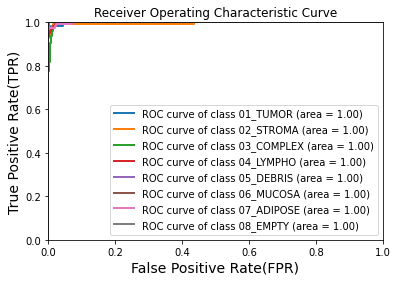

In [ ]:
roc_curve_multi(pred_all, label_all.astype('int'), f"AUROC_curve.png", target_names)

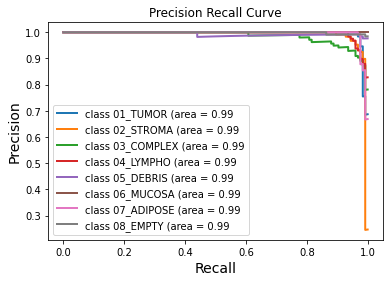

In [ ]:
prauc_curve_multi(pred_all, label_all.astype('int'), f"Precision_Recall_curve.png", target_names)

# 모델 결과 설명하기

In [ ]:
# gradCAM 모듈 설치
!pip install grad-cam

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.image import show_cam_on_image
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from PIL import Image

val_transformer = transforms.Compose([
    transforms.Resize(size=224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0,0,0], std=[1,1,1])
])

def show_gradCAM(model, class_num, img):
  """gradCAM을 이용하여 활성화맵(activation map)을 이미지 위에 시각화하기
  args:
    model: 학습된 모델
    class_num: 클래스 번호 ['01_TUMOR', '02_STROMA', '03_COMPLEX', '04_LYMPHO', '05_DEBRIS', '06_MUCOSA', '07_ADIPOSE', '08_EMPTY']
    img: 시각화 할 입력 이미지
  """
  target_layers = [model.layer4[-1]] # 출력층 이전 마지막 레이어 가져오기
  cam = GradCAM(model=model, target_layers=target_layers, use_cuda=True)

  inp = val_transformer(img).unsqueeze(0) # 입력 이미지 텐서로 변환
  targets = [ClassifierOutputTarget(class_num)] # 타겟 지정
  grayscale_cam = cam(input_tensor=inp, targets=targets)
  grayscale_cam = grayscale_cam[0, :]

  # 활성화맵을 이미지 위에 표시
  visualization = show_cam_on_image(inp.squeeze(0).permute(1, 2, 0).numpy(), grayscale_cam, use_rgb=True)

  pil_image=Image.fromarray(visualization)
  return pil_image


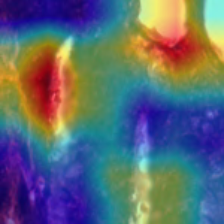

In [ ]:
# TUMOR 예시
tumor = Image.open('/content/training_dataset/01_TUMOR/1109D_CRC-Prim-HE-01_042.tif_Row_1_Col_451.tif')
tumor_cam = show_gradCAM(model, 0, tumor)
tumor_cam


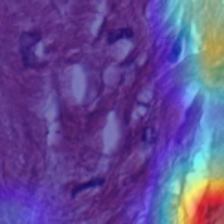

In [ ]:
# STROMA 예시
stroma = Image.open('/content/training_dataset/02_STROMA/10257_CRC-Prim-HE-03_015.tif_Row_301_Col_301.tif')
stroma_cam = show_gradCAM(model, 1, stroma)
stroma_cam

# 수고하셨습니다.